In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1)

import missingno as msno    # 누락값 표시
import warnings
import mglearn
warnings.filterwarnings('ignore')  # 워닝 무시
from sklearn.model_selection import train_test_split
%matplotlib inline

## 교차 검증(cross-validation)

#### k-fold cross-validation

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target, cv=3)
print(scores)
print(scores.mean())

[0.98 0.96 0.98]
0.9733333333333333


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
stkfold = StratifiedKFold(n_splits=5)
kfold = KFold(n_splits=5, shuffle=True,)
print(cross_val_score(logreg, iris.data, iris.target, cv=stkfold).mean())
cross_val_score(logreg, iris.data, iris.target, cv=kfold).mean()

0.9733333333333334


0.96

#### LOOCV(LeaveOneOut)

In [4]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print(len(scores), '{:2f}'.format(scores.mean()))

150 0.966667


#### 임의 분할 교차 검증(ShuffleSplit)

In [5]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(train_size=.5, test_size=.3, n_splits=10, random_state=0)
score = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
score

array([0.97777778, 0.93333333, 0.95555556, 0.88888889, 0.97777778,
       0.93333333, 0.97777778, 0.97777778, 1.        , 0.97777778])

#### 그룹별 교차 검증(GroupKFold)

In [6]:
from sklearn.model_selection import GroupKFold
from sklearn.datasets import make_blobs
# 인위적 데이터셋 생성
X, y = make_blobs(n_samples=13, random_state=0)
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
scores

array([0.75, 0.6 , 1.  ])

## 그리드 서치(grid search)

#### 검증 세트 활용하기

In [12]:
from sklearn.svm import SVC

X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
X_train, X_valid, y_train, y_valid =  train_test_split(X_trainval, y_trainval, random_state=1)
                                                      
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        score = svm.score(X_valid, y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print('{:.2f}'.format(best_score))
print(best_parameters)
print('{:.2f}'.format(test_score))

0.96
{'C': 10, 'gamma': 0.001}
0.92


#### 교차 검증 활용하기

In [ ]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        svm = SVC(gamma=gamma, C=C)
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C, 'gamma':gamma}
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

In [54]:
# GridSearchCV 활용하기
from sklearn.model_selection import GridSearchCV
# 딕셔너리 형태로 검색 대상 매개변수를 지정해야한다.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
grid_search.fit(X_train, y_train)
grid_search.predict(X_test)
grid_search.score(X_test, y_tiyest)
grid_search.best_params_

{'C': 10, 'gamma': 0.1}

#### 교차 검증 결과 분석(시각화)

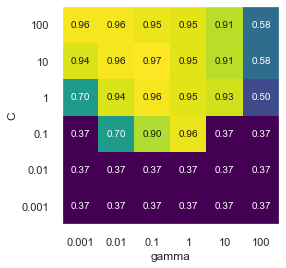

In [25]:
# 검색 대상 매개변수 그리드가 2차원이므로 heatmap으로 시각화하기 좋다.

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(6,6)

mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                     ylabel='C', yticklabels=param_grid['C'], cmap='viridis')

AttributeError: 'AxesSubplot' object has no attribute 'tolist'

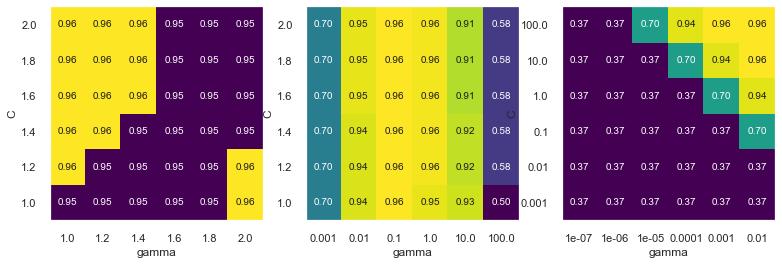

In [34]:
f, ax = plt.subplots(1, 3, figsize=(13,5))
param_grid_linear = {'C': np.linspace(1,2,6), 'gamma': np.linspace(1,2,6)}
param_grid_one_log = {'C': np.linspace(1,2,6), 'gamma': np.logspace(-3,2,6)}
param_grid_range = {'C': np.logspace(-3,2,6), 'gamma': np.logspace(-7,-2,6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], ax):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)

    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap='viridis', ax=ax)
plt.colorbar(scores_image, ax=ax.tolist())

#### 비대칭 매개변수 그리드 서치

In [40]:
param_grid = [{'kernel': ['rbf'],'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, 
              {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

#### 중첩 교차 검증

In [53]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
scores = cross_val_score(grid_search, iris.data, iris.target, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [44]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    for training_samples, test_samples in outer_cv.split(X,y):
        best_params = {}
        best_score = -np.inf
        for parameters in parameter_grid:
            cv_scores = []
            
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                best_score = mean_score  
                best_params = parameters
                
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [50]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, StratifiedShuffleSplit
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

## 평가 지표와 측정

#### 이진 분류의 평가 지표

#### 다중 분류의 평가 지표

#### 회귀의 평가 지표

#### 모델 선택에서 평가 지표 사용하기